In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Import scripts

In [4]:
path_scripts = '/Users/simjoo/Projects/10X_PDAC_Lgr5/scripts/v3/'

In [5]:
import sys
sys.path.append(path_scripts)

In [6]:
from ipyparallel import Client
import csv
import os
import pickle
import scipy.io
import scanpy as sc
import anndata
import bbknn
import statsmodels.api as sm
import gseapy as gp
import phenograph as pg
import ternary

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/numba/core/cpu.py:77: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()


In [7]:
%R library(Seurat)
%R library(SingleCellExperiment)
%R library(scran)
%R library(DropletUtils)
%R library(DESeq2)

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted

array(['DESeq2', 'DropletUtils', 'scran', 'SingleCellExperiment',
       'SummarizedExperiment', 'DelayedArray', 'BiocParallel',
       'matrixStats', 'Biobase', 'GenomicRanges', 'GenomeInfoDb',
       'IRanges', 'S4Vectors', 'BiocGenerics', 'parallel', 'stats4',
       'Seurat', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U20')

In [8]:
from TenX_PDAC_misc_scripts_v1_0 import *
from TenX_PDAC_plot_v1_0 import *
from TenX_PDAC_mann_whitney_u_v1_0 import *

In [9]:
#exp_id = create_ID()

In [10]:
exp_id = '202110251102'
path_input = '/Users/simjoo/Projects/10X_PDAC_Lgr5/data_input/'
path_output = '/Users/simjoo/Projects/10X_PDAC_Lgr5/data_output/v3/'
path_figures = '/Users/simjoo/Projects/10X_PDAC_Lgr5/figures/v3/'

In [11]:
cmap_tab20 = {str(c) : mpl.colors.rgb2hex(plt.cm.tab20(c/20)) for c in range(20)}
cmap_tumor = {'autochthonous':'#d95f02', 'fragment_transplant':'#1b9e77', 'sorted_transplant':'#7570b3',
              '2D':'#e7298a','3D_2%':'#66a61e','3D_Tuv':'#e6ab02',}
cmap_treatment = {'3d_TAM':'#addd8e','10d_Veh':'#31a354','20d_TAM':'#006837',
                  '10d_LGK':'#fd8d3c','20d_LGK':'#bd0026','10d_Gem':'#2c7fb8'}
cmap_lineage_tracing = {'tdTomato': '#d95f02', 'Negative': 'silver', 'tdTomato-GFP': '#e6ab02', 'GFP': '#66a61e'}
cmap_cl_tumor = {'Luminal cells':'#7570b3',
               'Basal cells':'#1b9e77',
               'Mesenchymal cells':'#d95f02',
                 'Other':'silver'}

# Initialize engines

In [12]:
c = Client()

In [13]:
dview = c[:]

In [14]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/10X_PDAC_Lgr5/scripts/v3/")')
dview.execute('from TenX_PDAC_misc_scripts_v1_0 import *')
dview.execute('from TenX_PDAC_plot_v1_0 import *')
dview.execute('from TenX_PDAC_mann_whitney_u_v1_0 import *')

<AsyncResult: execute>

# Marker gene and signature expression

In [15]:
X = sc.read_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))
Xs = sc.read_h5ad('%s/%s_Xs_PDAC_Lgr5_tumor_aut.h5' % (path_output, exp_id))

## Exclude LGK-treated cells

In [16]:
c_sel = Xs.obs[Xs.obs['treatment']!='LGK-974'].index

In [17]:
len(c_sel)

14392

In [18]:
Xs = Xs[c_sel]

## Plot marker genes

In [24]:
pdX = sc2pd(X, 'norm_log2')

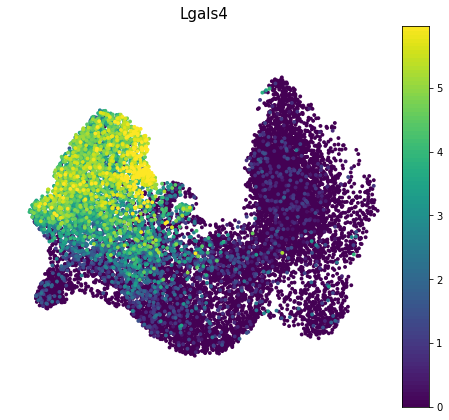

In [20]:
g = 'Lgals4'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

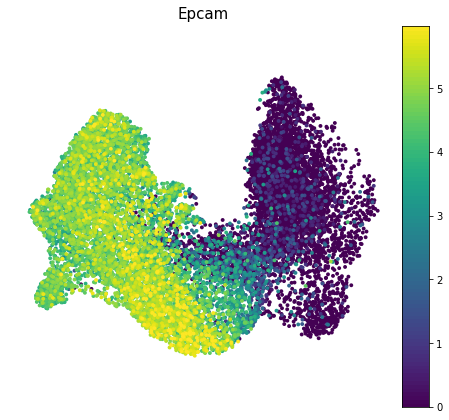

In [23]:
g = 'Epcam'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

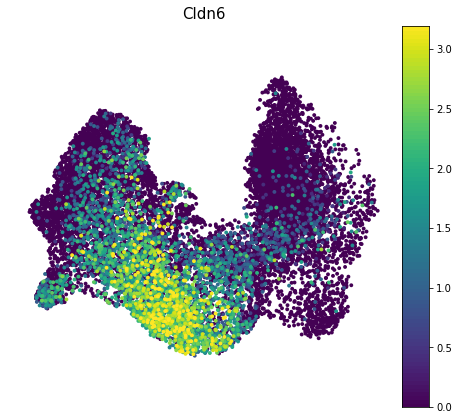

In [25]:
g = 'Cldn6'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

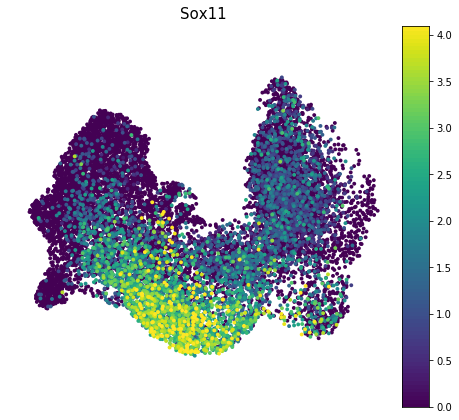

In [26]:
g = 'Sox11'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

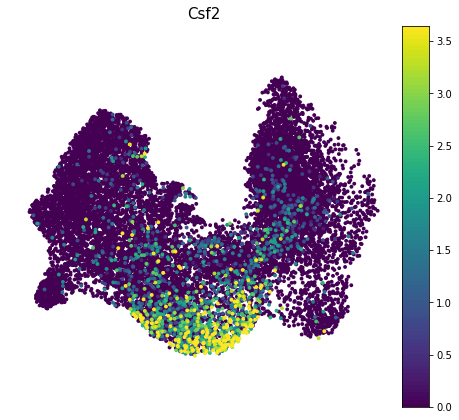

In [27]:
g = 'Csf2'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

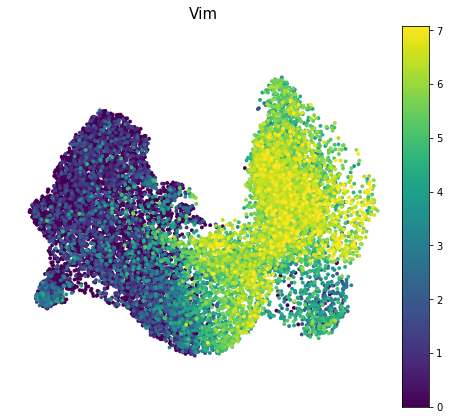

In [28]:
g = 'Vim'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

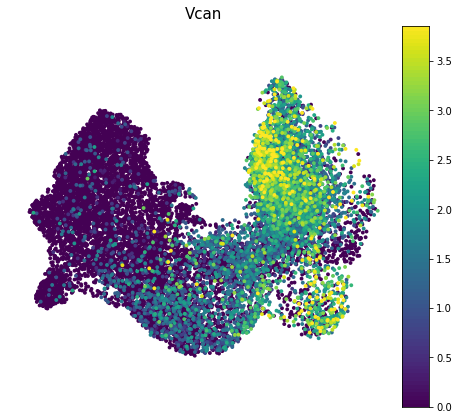

In [30]:
g = 'Vcan'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

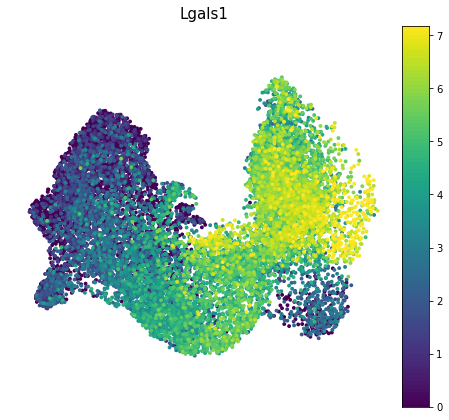

In [31]:
g = 'Lgals1'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

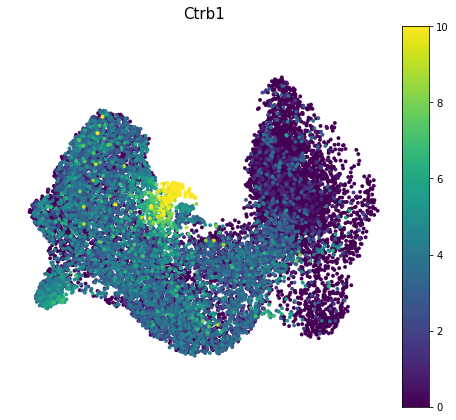

In [125]:
g = 'Ctrb1'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  0,
                  10,
                  text = g,
                  s = 15, show_axes=False)

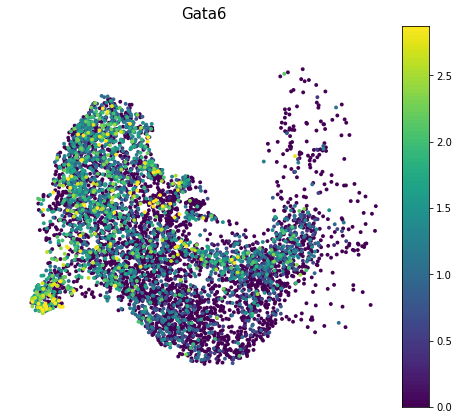

In [237]:
g = 'Gata6'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

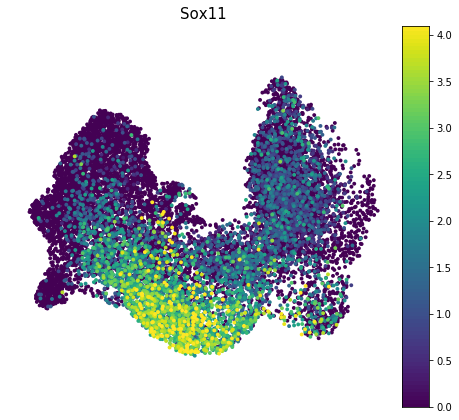

In [21]:
g = 'Sox11'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

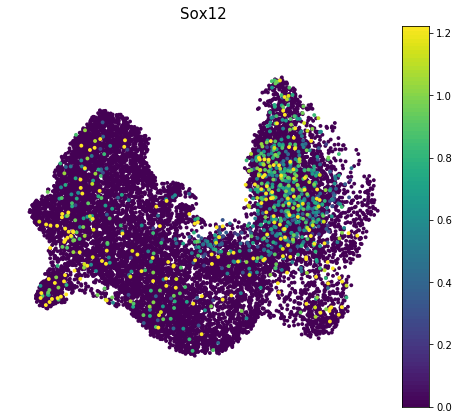

In [22]:
g = 'Sox12'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

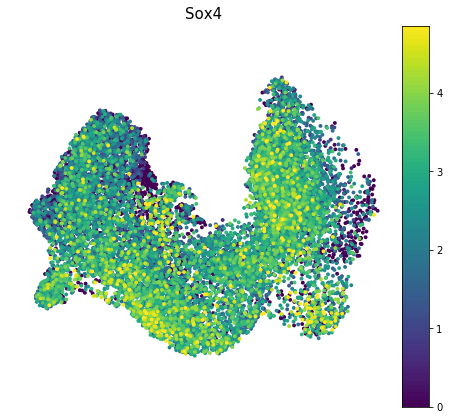

In [23]:
g = 'Sox4'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

## Get MaxAbs scaled data

In [19]:
from sklearn.preprocessing import MaxAbsScaler

In [20]:
X_scaled = X[Xs.obs_names]

In [21]:
X_scaled.X = X_scaled.layers['norm_log2']

In [22]:
X_scaled.X = MaxAbsScaler().fit_transform(X_scaled.X)

## Expression of Wnt signatures

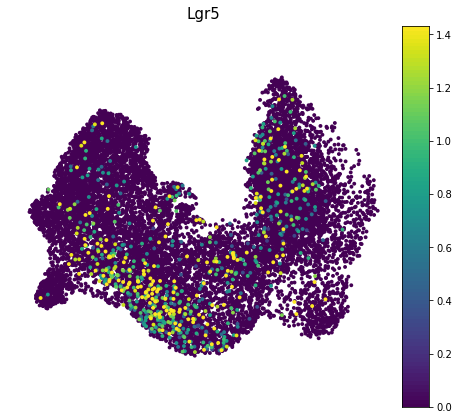

In [25]:
g = 'Lgr5'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

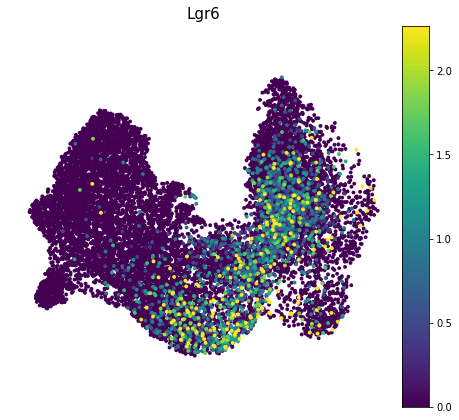

In [55]:
g = 'Lgr6'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

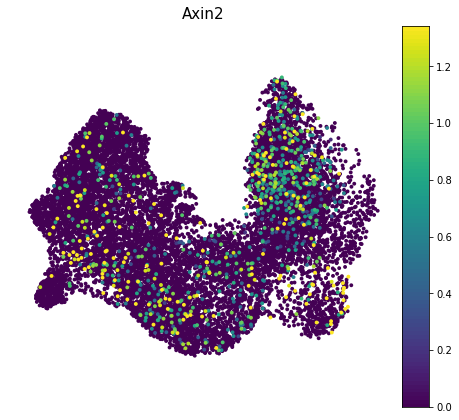

In [26]:
g = 'Axin2'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

### HALLMARK_WNT_BETA_CATENIN_SIGNALING (M5895)

In [67]:
sig_M5895 = open('%s/M5895.txt' % path_input, 'r').readlines()[2:]
sig_M5895 = [i.replace('\n','').capitalize() for i in sig_M5895]

In [90]:
len(sig_M5895)

42

In [79]:
sc.tl.score_genes(X_scaled, sig_M5895, ctrl_size=len(sig_M5895), score_name='score_M5895')

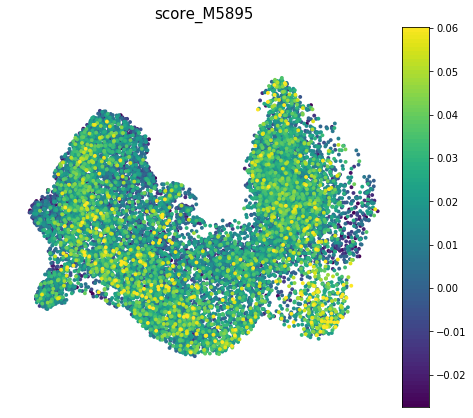

In [81]:
g = 'score_M5895'
expr = X_scaled.obs[g][Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

### KEGG_WNT_SIGNALING_PATHWAY (M19428)

In [83]:
sig_M19428 = open('%s/M19428.txt' % path_input, 'r').readlines()[2:]
sig_M19428 = [i.replace('\n','').capitalize() for i in sig_M19428]

In [91]:
len(sig_M19428)

151

In [84]:
sc.tl.score_genes(X_scaled, sig_M19428, ctrl_size=len(sig_M19428), score_name='score_M19428')

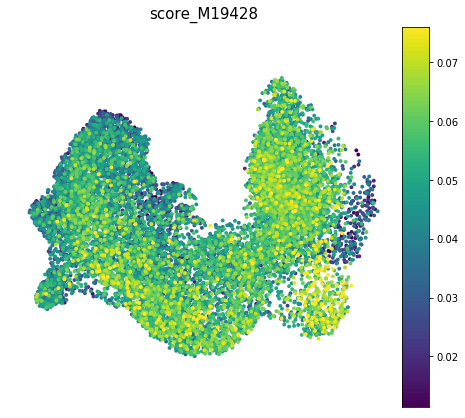

In [85]:
g = 'score_M19428'
expr = X_scaled.obs[g][Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

### REACTOME_SIGNALING_BY_WNT (M7847)

In [86]:
sig_M7847 = open('%s/M7847.txt' % path_input, 'r').readlines()[2:]
sig_M7847 = [i.replace('\n','').capitalize() for i in sig_M7847]

In [92]:
len(sig_M7847)

331

In [87]:
sc.tl.score_genes(X_scaled, sig_M7847, ctrl_size=len(sig_M7847), score_name='score_M7847')

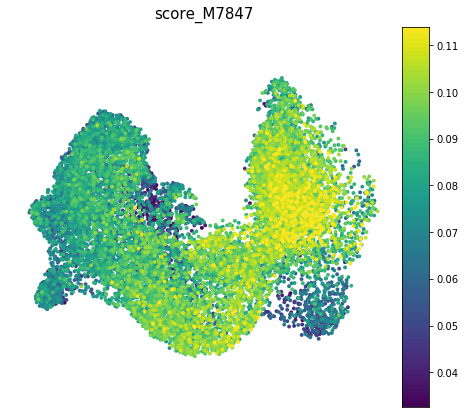

In [88]:
g = 'score_M7847'
expr = X_scaled.obs[g][Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

### Tammela WNT signature

In [27]:
sig_WNT_TT = ['Fn1','Myc','Tcf7','Lef1','Ppard','Cd44','Axin2','Birc5','Id2','Lgr5','Ccnd1']

In [28]:
len(sig_WNT_TT)

11

In [29]:
sc.tl.score_genes(X_scaled, sig_WNT_TT, ctrl_size=len(sig_WNT_TT), score_name='score_WNT_TT')

Trying to set attribute `.obs` of view, copying.


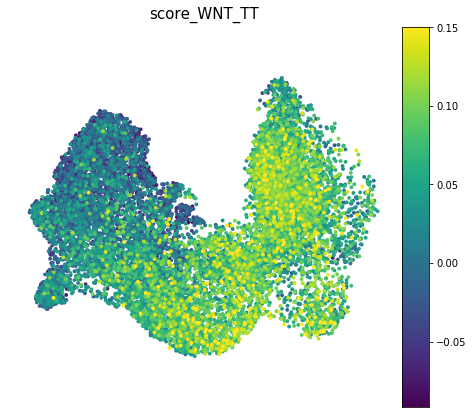

In [33]:
g = 'score_WNT_TT'
expr = X_scaled.obs[g][Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

## LUAD High plasticity state signature

In [94]:
sig_HPS = open('%s/LUAD_cluster_5.txt' % path_input, 'r').readlines()
sig_HPS = [i.replace('\n','').capitalize() for i in sig_HPS]

In [95]:
len(sig_HPS)

406

In [98]:
sc.tl.score_genes(X_scaled, sig_HPS, ctrl_size=len(sig_HPS), score_name='score_HPS')

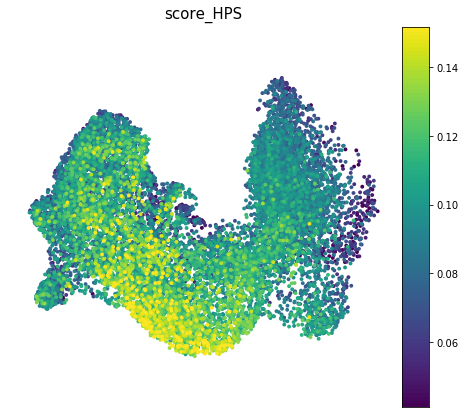

In [99]:
g = 'score_HPS'
expr = X_scaled.obs[g][Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

## Moffit et al. basal and classical states

In [100]:
moffit = pd.read_table('%s/41588_2015_BFng3398_MOESM62_ESM.txt' % path_input, sep = '\t', header = 0, index_col = 0)

In [103]:
moffit_gene_sets = moffit['factor']
moffit_gene_sets.index = [i.capitalize() for i in moffit_gene_sets.index]

In [105]:
genes_moffit_basal = moffit_gene_sets[moffit_gene_sets==6].index
genes_moffit_classical = moffit_gene_sets[moffit_gene_sets==8].index

In [106]:
len(genes_moffit_basal)

796

In [107]:
len(genes_moffit_classical)

1012

In [109]:
#sc.tl.score_genes(X_scaled, genes_moffit_basal, ctrl_size=len(genes_moffit_basal), score_name='score_moffit_basal')
#sc.tl.score_genes(X_scaled, genes_moffit_classical, ctrl_size=len(genes_moffit_classical), score_name='score_moffit_classical')

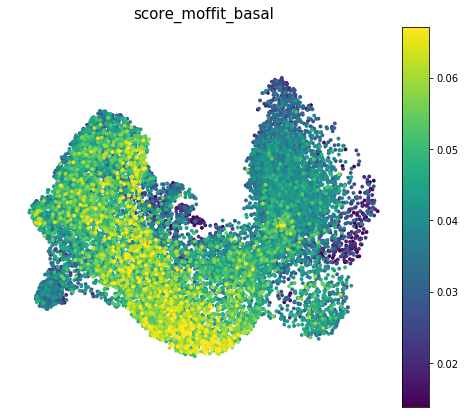

In [110]:
g = 'score_moffit_basal'
expr = X_scaled.obs[g][Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

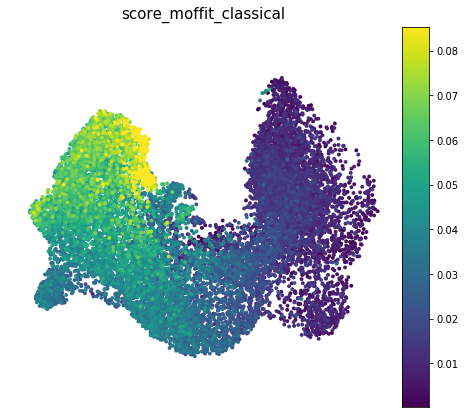

In [111]:
g = 'score_moffit_classical'
expr = X_scaled.obs[g][Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

## Shannon entropy

In [46]:
pdX = sc2pd(X, 'norm')[Xs.obs_names]

In [47]:
pdX_norm = pdX.apply(lambda x: x / np.sum(x), axis = 0)

In [48]:
ent = pd.Series(scipy.stats.entropy(pdX_norm, axis = 0), index = pdX_norm.columns)

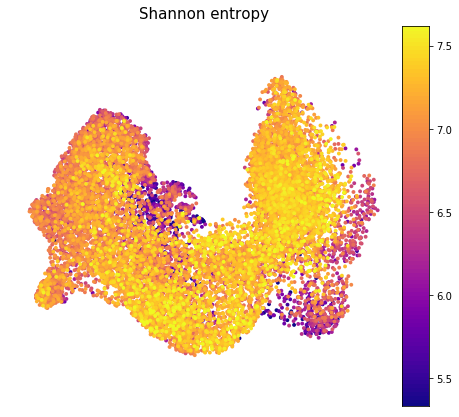

In [54]:
expr = ent
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  cmap=plt.cm.plasma,
                  text = 'Shannon entropy',
                  s = 15, show_axes=False)

# Intertumoral heterogeneity in autocthonous tumors

In [126]:
X = sc.read_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))
Xs = sc.read_h5ad('%s/%s_Xs_PDAC_Lgr5_tumor_aut.h5' % (path_output, exp_id))

## Exclude LGK-treated cells

In [127]:
c_sel = Xs.obs[Xs.obs['treatment']!='LGK-974'].index

In [128]:
len(c_sel)

14392

In [129]:
Xs = Xs[c_sel]

## On Umap

In [138]:
cmap_mouse = {i:mpl.colors.rgb2hex(plt.cm.tab20(p/20)) for p, i in enumerate(set(Xs.obs['mouse']))}

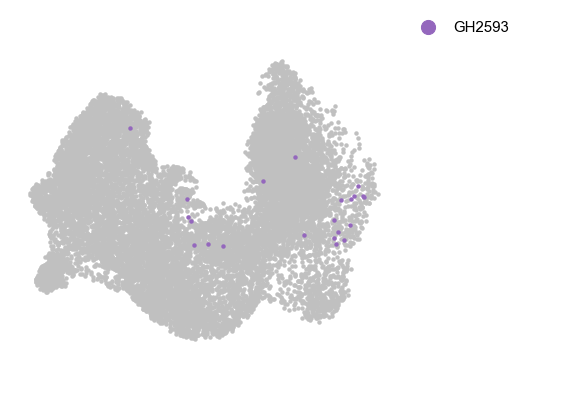

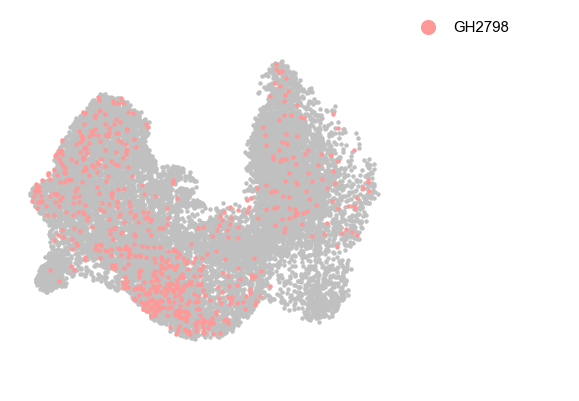

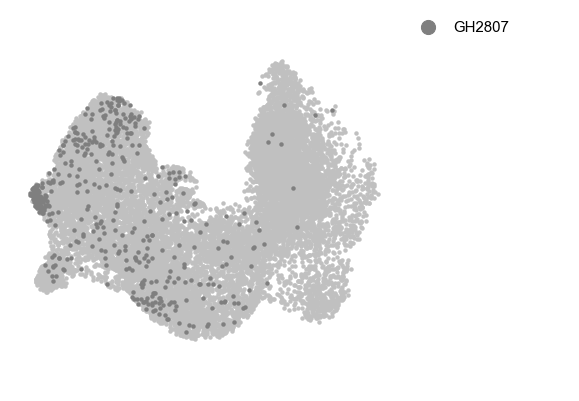

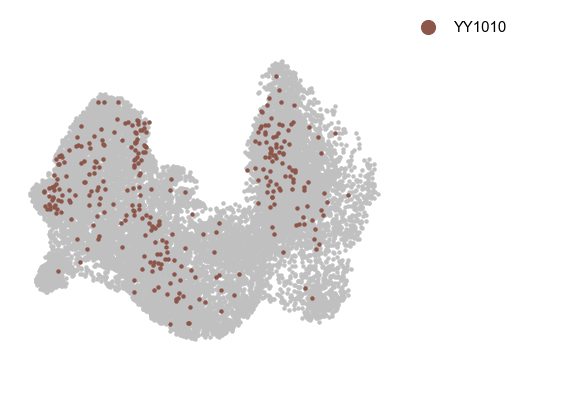

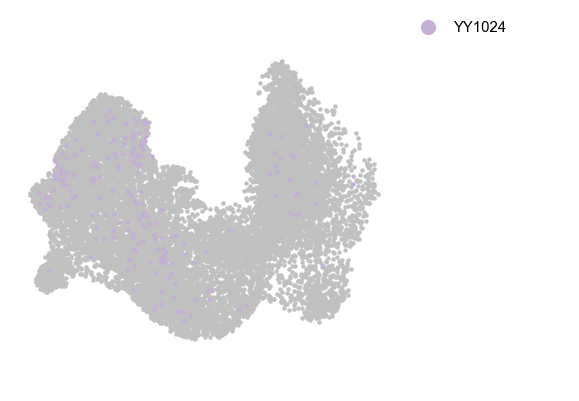

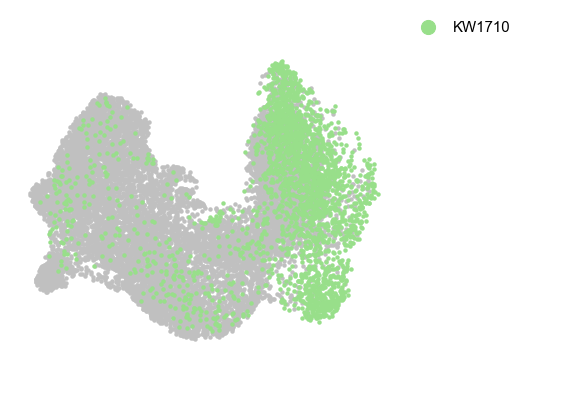

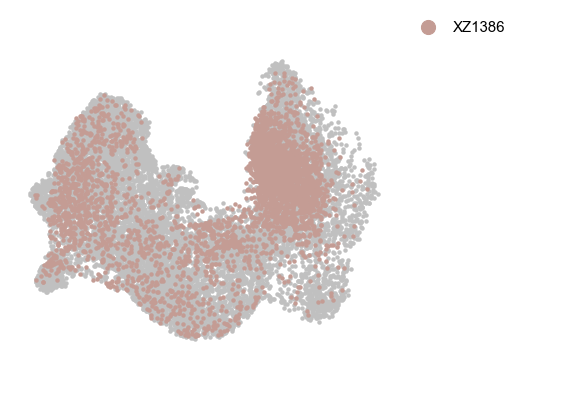

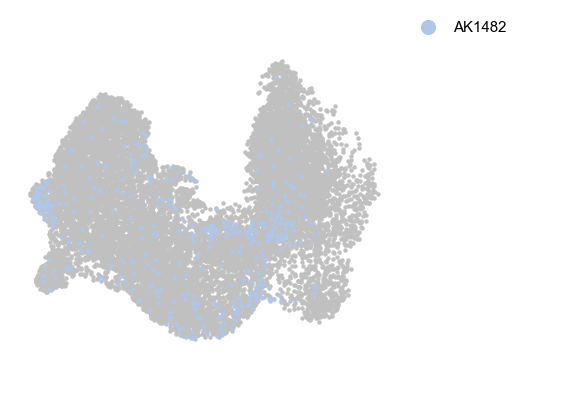

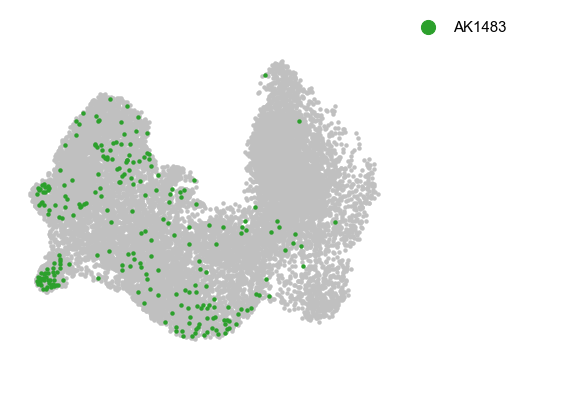

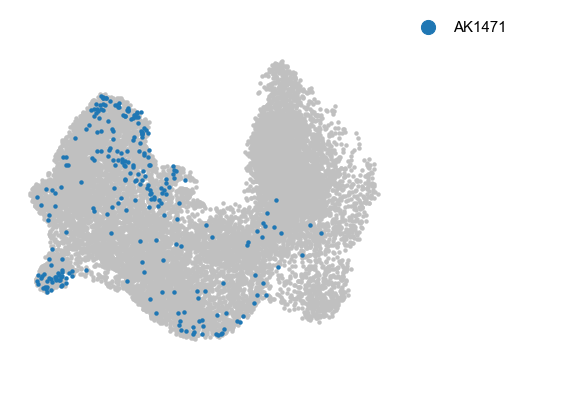

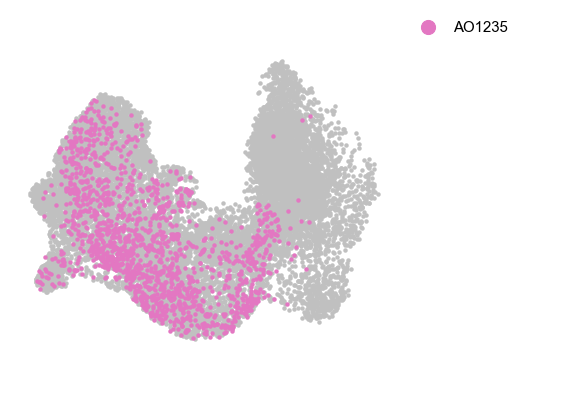

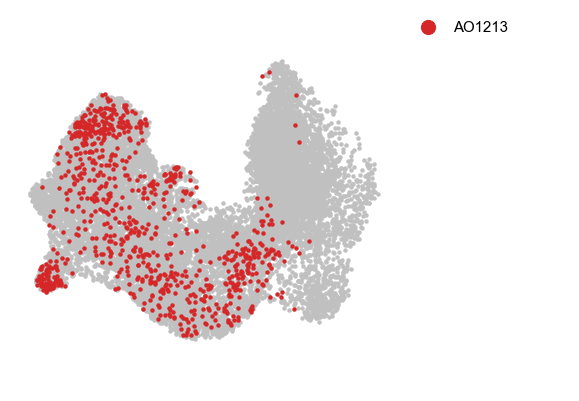

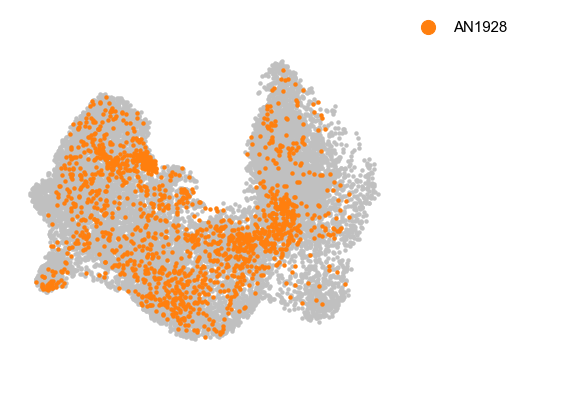

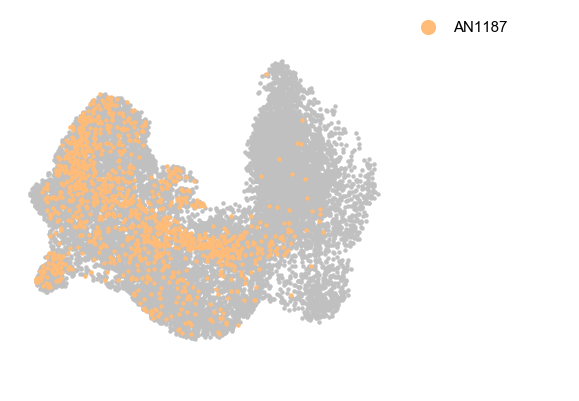

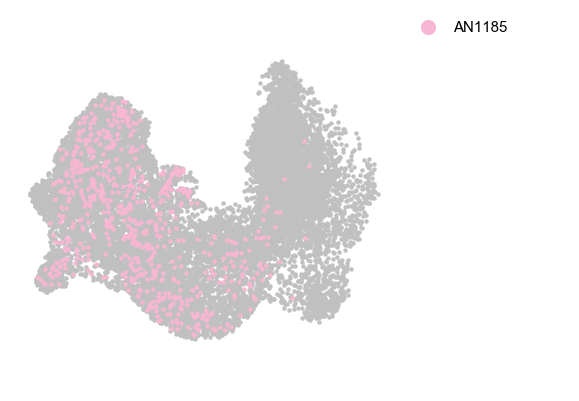

In [141]:
draw_scatter_groups_individual(Xs.obsm['X_umap_pca'], 
                               Xs.obs['mouse'],
                               cmap=cmap_mouse,
                               s=20, show_axes = False)

## Along pseudotime

In [142]:
def draw_violin_pseudotime(adata, dpt_var, group_var, cmap=plt.cm.tab20, gr_order=None, scatter=False, bw='scott'):
    
    assert dpt_var in adata.obs.columns, 'dpt_var not in adata'
    dpt = adata.obs[dpt_var]
    
    assert group_var in adata.obs.columns, 'group_var not in adata'
    groups = adata.obs[group_var]
    
    L = len(set(groups))
    
    if not gr_order:
        gr_order = return_unique(groups)
    
    #initialize figure

    height = 1 * L
    width = 10

    plt.figure(facecolor = 'w', figsize = (width, height))
    
    #define colormap
    
    if type(cmap) != dict:
        cm = cmap
        cmap = {}
        for ix, gr in enumerate(return_unique(groups)):
            cmap[gr] = cm(float(ix) / 20)
            
    clist = [cmap[groups[c]] for c in groups.index]
    
    #define x and y axes

    ax = plt.subplot()
    
    ax.set_xlim(0,1)
    ax.set_xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    ax.set_xticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], family = 'Arial', fontsize = 20, rotation = 'vertical')
    ax.set_xlabel('Pseudotime', family = 'Arial', fontsize = 30)
    
    ax.set_ylim(L-0.5,-0.5)
    ax.set_yticks(range(0,L))
    ax.set_yticklabels(gr_order, family = 'Arial', fontsize = 20)

    
    #plot data

    for p, i in enumerate(gr_order):

        i_tmp = groups[groups==i].index
        d_tmp = dpt[i_tmp].values
        
        if scatter:
            ax.scatter(d_tmp,
                       [p-(i-0.5)/2 for i in np.random.rand(len(d_tmp), 1)],
                        color = 'k',
                        s = 1,
                        alpha = 0.25,
                        zorder = 1)

        violin = ax.violinplot([d_tmp],
                                positions = [p],
                                vert=False,
                                showextrema=False,
                                widths=0.95, 
                               bw_method=bw)

        for v in violin['bodies']:
            v.set_facecolor(cmap[i])
            v.set_linewidth(0)
            v.set_alpha(0.75)
            v.set_zorder(0)

        ax.axhline(p, color='k', linewidth=2)

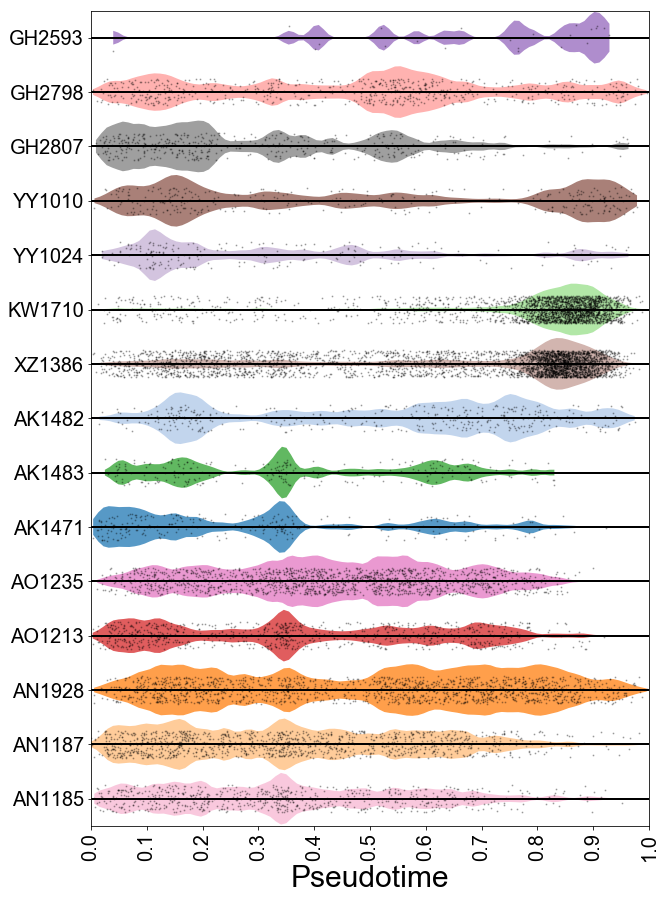

In [143]:
draw_violin_pseudotime(Xs, 'dpt_pseudotime_pca', 'mouse', cmap=cmap_mouse, gr_order=None, bw=0.05, scatter=True)

# Lineage tracing of autochthonous tumors

In [15]:
X = sc.read_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))
Xs = sc.read_h5ad('%s/%s_Xs_PDAC_Lgr5_tumor_aut.h5' % (path_output, exp_id))
Xs_ = sc.read_h5ad('%s/%s_Xs_PDAC_Lgr5_tumor_fit_on_aut.h5' % (path_output, exp_id))

In [16]:
Xs.obs[['pheno_prob0_pca','pheno_prob1_pca','pheno_prob2_pca','pheno_class_pca']] = Xs_.obs[['pheno_prob0_pca','pheno_prob1_pca','pheno_prob2_pca','pheno_class_pca']].loc[Xs.obs_names]

## Select lineage traced samples

In [17]:
c_sel = Xs.obs[Xs.obs['batch'].isin(['OG-1331_Day3_100621','AS-1258_D10Tam_Autoch_plus_mTmGFrag_NSGFrag'])].index

In [18]:
len(c_sel)

5812

In [19]:
Xs = Xs[c_sel]

## Plot UMAP distribution of lineage traced samples

In [20]:
cmap_mouse = {i:mpl.colors.rgb2hex(plt.cm.tab20(p/20)) for p, i in enumerate(set(Xs.obs['mouse']))}

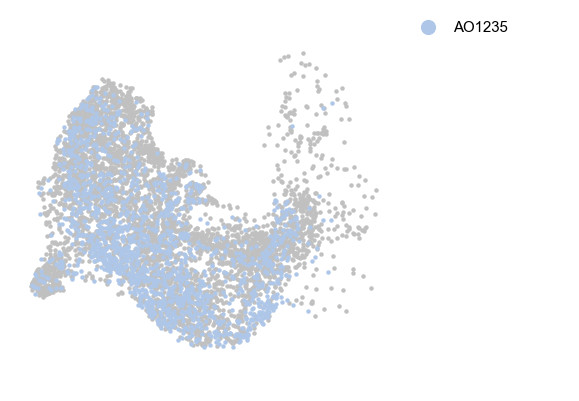

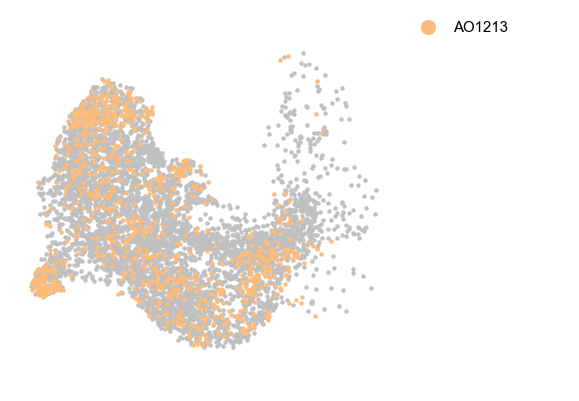

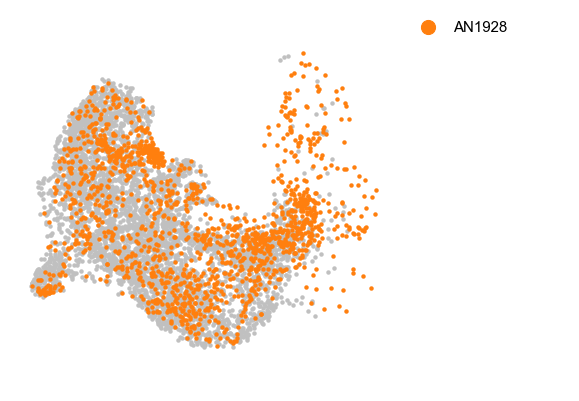

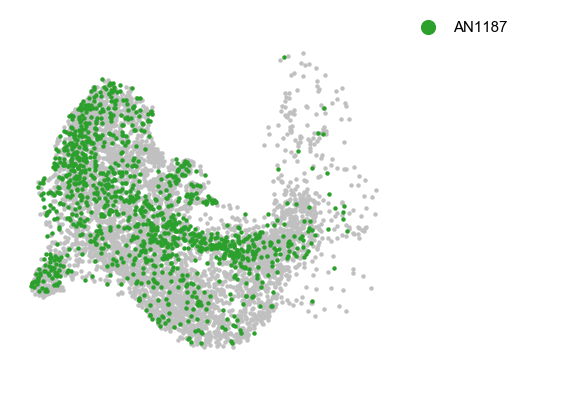

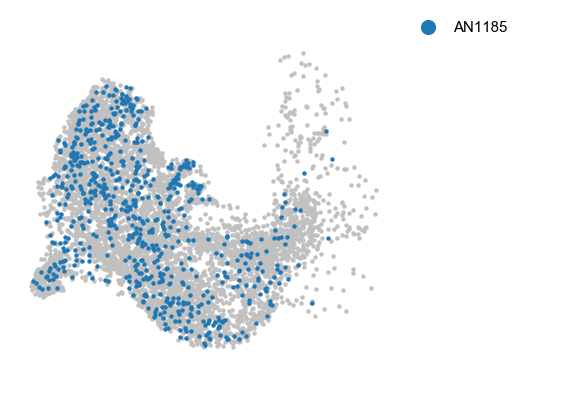

In [21]:
draw_scatter_groups_individual(Xs.obsm['X_umap_pca'], 
                               Xs.obs['mouse'],
                               cmap=cmap_mouse,
                               s=20, show_axes = False)

## Stratify cells according to mTmG status

In [22]:
TMX_3d = Xs.obs[Xs.obs['batch'].isin(['OG-1331_Day3_100621'])].index
TMX_10d = Xs.obs[Xs.obs['batch'].isin(['AS-1258_D10Tam_Autoch_plus_mTmGFrag_NSGFrag'])].index

In [23]:
dat = Xs.obs[['tdTomato','GFP']].T

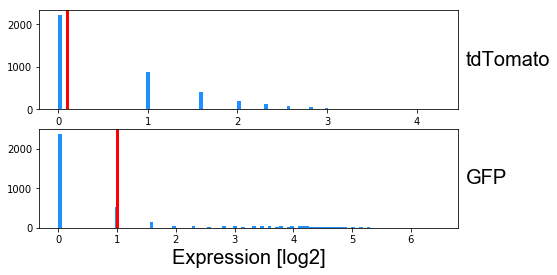

In [24]:
plot_hashes(dat[TMX_3d], thr = [0.1,1])

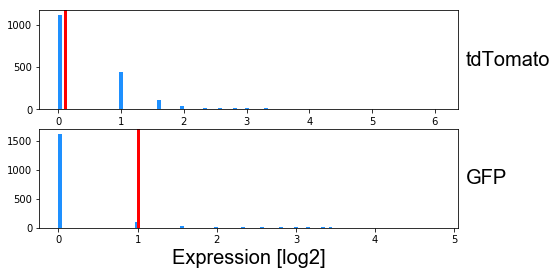

In [25]:
plot_hashes(dat[TMX_10d], thr = [0.1,1])

In [26]:
Xs.obs['lineage_tracing'] = assign_hashes(dat, thr = [0,1], log=False)
Xs.obs['lineage_tracing'][Xs.obs['lineage_tracing']=='tdTomato-GFP'] = 'GFP'

Trying to set attribute `.obs` of view, copying.
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
Counter(Xs.obs['lineage_tracing'])

Counter({'GFP': 1166, 'Negative': 3111, 'tdTomato': 1535})

In [28]:
Counter(Xs.obs['lineage_tracing'][TMX_3d])

Counter({'GFP': 1037, 'Negative': 2001, 'tdTomato': 919})

In [29]:
Counter(Xs.obs['lineage_tracing'][TMX_10d])

Counter({'tdTomato': 616, 'Negative': 1110, 'GFP': 129})

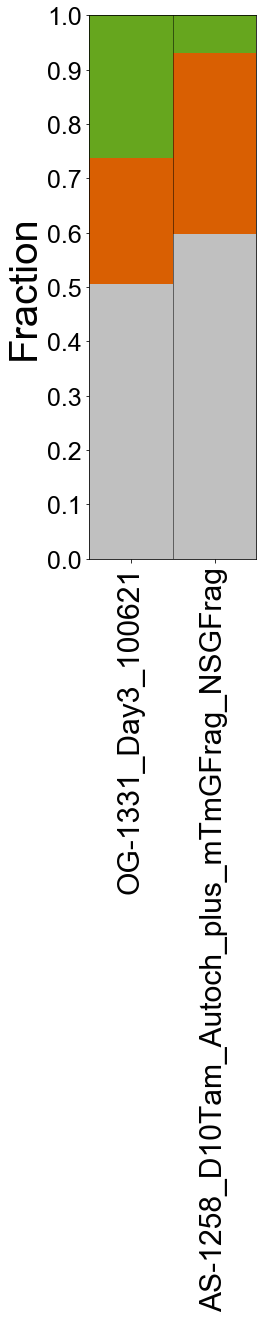

In [30]:
draw_fraction_cluster(Xs.obs['batch'], 
                      Xs.obs['lineage_tracing'], 
                      cmap_lineage_tracing, var_order=['Negative','tdTomato','GFP'])

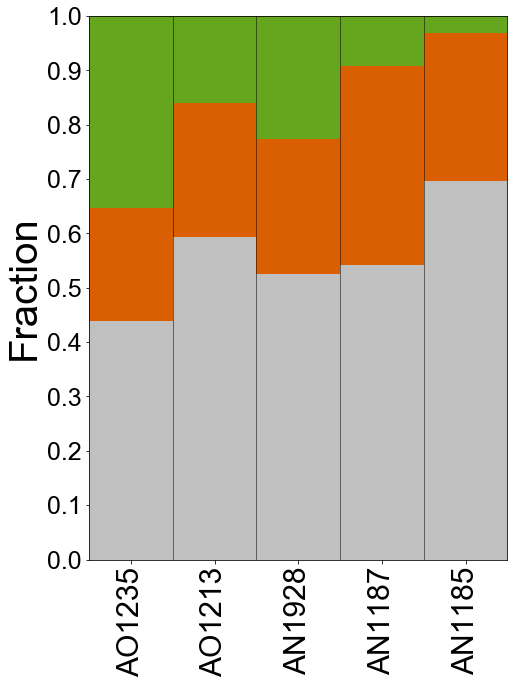

In [31]:
draw_fraction_cluster(Xs.obs['mouse'], 
                      Xs.obs['lineage_tracing'], 
                      cmap_lineage_tracing, var_order=['Negative','tdTomato','GFP'])

## Lgr5 expression in lineage tracing groups stratified according to batch

In [32]:
def draw_bars(data, groups, cmap=plt.cm.tab20, gr_order=None, scatter=False, ylim=None):
    
    if not gr_order:
        gr_order = return_unique(groups)
        
    L = len(gr_order)
    
    #initialize figure

    height = 6
    width = 2 * L

    plt.figure(facecolor = 'w', figsize = (width, height))
    
    #define colormap
    
    if type(cmap) != dict:
        cm = cmap
        cmap = {}
        for ix, gr in enumerate(return_unique(groups)):
            cmap[gr] = cm(float(ix) / 20)
            
    clist = [cmap[groups[c]] for c in groups.index]

    #define x and y axes

    ax = plt.subplot()

    ax.set_xlim(-0.5, L-0.5)
    ax.set_xticks(range(L))
    ax.set_xticklabels(gr_order, family = 'Arial', fontsize = 35, rotation = 'vertical')

    ax.set_ylabel('Mean expression', family = 'Arial', fontsize = 35)
    if ylim:
        ax.set_ylim(ylim)
    for tick_pos, tick in enumerate(ax.yaxis.get_major_ticks()):
            ax.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
            ax.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    #plot data

    for p, i in enumerate(gr_order):

        i_tmp = groups[groups==i].index
        d_tmp = data[i_tmp].values
        
        ax.bar(p, d_tmp.mean(), color = cmap[i], yerr = d_tmp.std()/np.sqrt(len(d_tmp)))

In [33]:
def draw_bars_fc(data, groups, cmap=plt.cm.tab20, gr_order=None, scatter=False, ylim=None, ref=None):
    
    if not gr_order:
        gr_order = return_unique(groups)
        
    if not ref:
        ref = gr_order[0]
        
    L = len(gr_order)
    
    #initialize figure

    height = 6
    width = 2 * L

    plt.figure(facecolor = 'w', figsize = (width, height))
    
    #define colormap
    
    if type(cmap) != dict:
        cm = cmap
        cmap = {}
        for ix, gr in enumerate(return_unique(groups)):
            cmap[gr] = cm(float(ix) / 20)
            
    clist = [cmap[groups[c]] for c in groups.index]

    #define x and y axes

    ax = plt.subplot()

    ax.set_xlim(-0.5, L-0.5)
    ax.set_xticks(range(L))
    ax.set_xticklabels(gr_order, family = 'Arial', fontsize = 35, rotation = 'vertical')

    ax.set_ylabel('Fold change', family = 'Arial', fontsize = 35)
    if ylim:
        ax.set_ylim(ylim)
    for tick_pos, tick in enumerate(ax.yaxis.get_major_ticks()):
            ax.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
            ax.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    #get ref data
    
    i_ref = groups[groups==ref].index
    d_ref = data[i_ref].values
    
    #plot data

    for p, i in enumerate(gr_order):

        i_tmp = groups[groups==i].index
        d_tmp = data[i_tmp].values
        
        ax.bar(p, d_tmp.mean()/d_ref.mean(), color = cmap[i], yerr = d_tmp.std()/np.sqrt(len(d_tmp)))

In [34]:
pdX = sc2pd(X,'norm_log2')[Xs.obs_names]

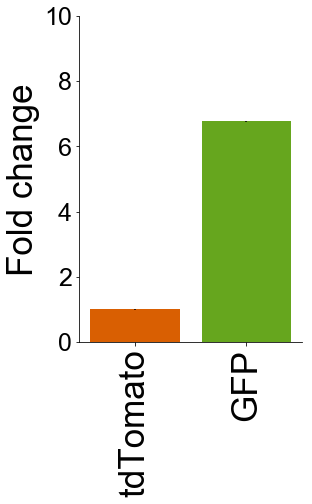

In [35]:
draw_bars_fc(pdX[TMX_3d].loc['Lgr5'],
          Xs.obs['lineage_tracing'][TMX_3d],
          cmap=cmap_lineage_tracing,
          gr_order=['tdTomato','GFP'],
          scatter=True, ylim = (0,10))

figname = 'bar_Lgr5_expr_auto_3d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

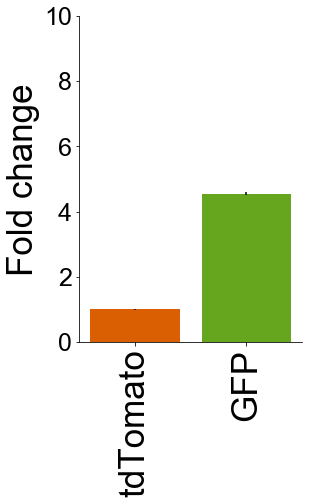

In [36]:
draw_bars_fc(pdX[TMX_10d].loc['Lgr5'],
          Xs.obs['lineage_tracing'][TMX_10d],
          cmap=cmap_lineage_tracing,
          gr_order=['tdTomato','GFP'],
          scatter=True, ylim = (0,10))

figname = 'bar_Lgr5_expr_auto_10d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Comparison of Lgr5 expression and GFP labeling

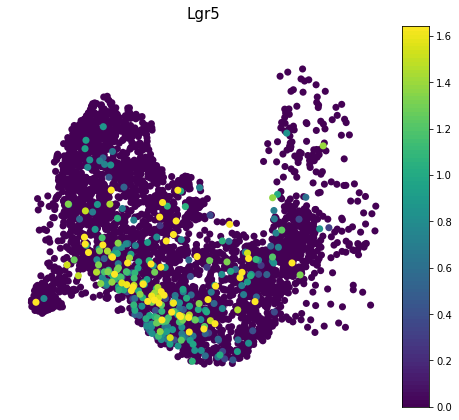

In [32]:
g = 'Lgr5'
expr = pdX.loc[g, TMX_3d]
draw_scatter_expr(Xs[TMX_3d].obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 50, show_axes=False)

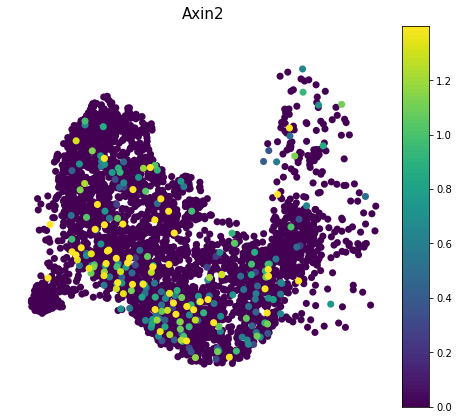

In [33]:
g = 'Axin2'
expr = pdX.loc[g, TMX_3d]
draw_scatter_expr(Xs[TMX_3d].obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 50, show_axes=False)

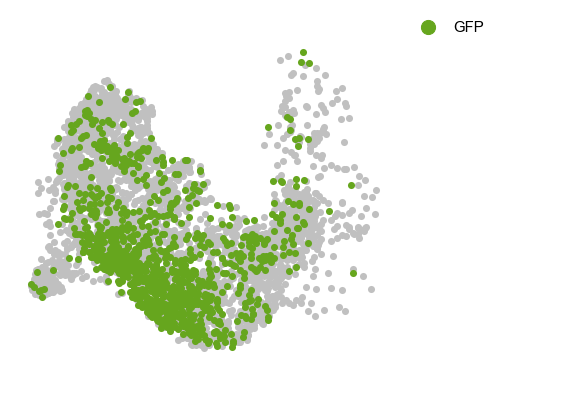

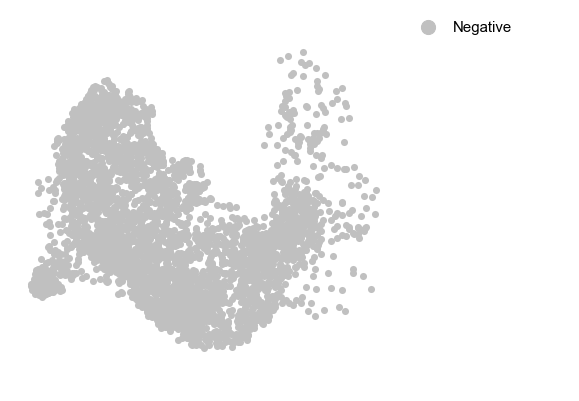

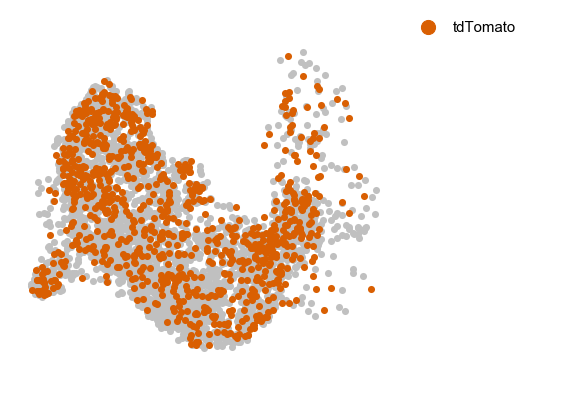

In [34]:
draw_scatter_groups_individual(Xs[TMX_3d].obsm['X_umap_pca'], 
                    Xs[TMX_3d].obs['lineage_tracing'],
                    cmap=cmap_lineage_tracing,
                    s=50, show_axes = False)

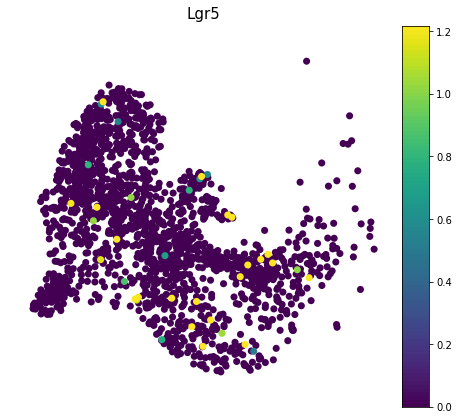

In [35]:
g = 'Lgr5'
expr = pdX.loc[g, TMX_10d]
draw_scatter_expr(Xs[TMX_10d].obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 50, show_axes=False)

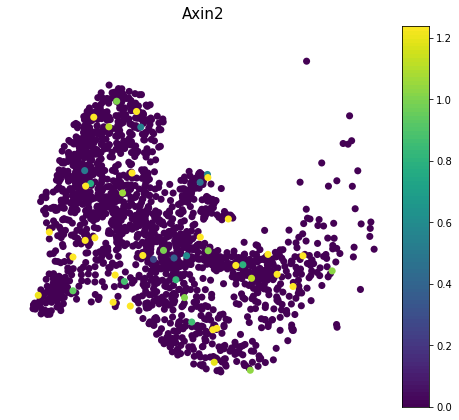

In [36]:
g = 'Axin2'
expr = pdX.loc[g, TMX_10d]
draw_scatter_expr(Xs[TMX_10d].obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 50, show_axes=False)

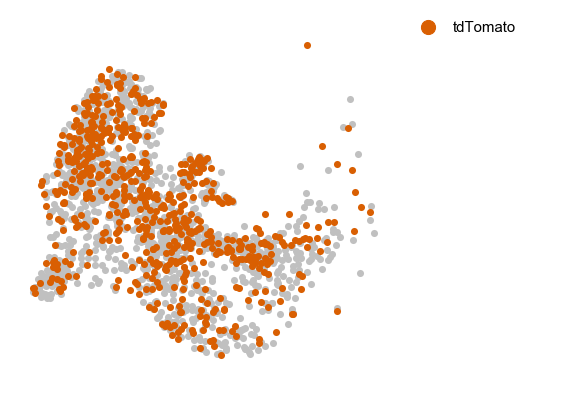

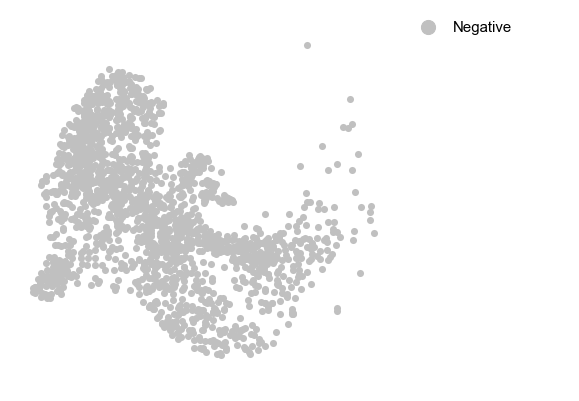

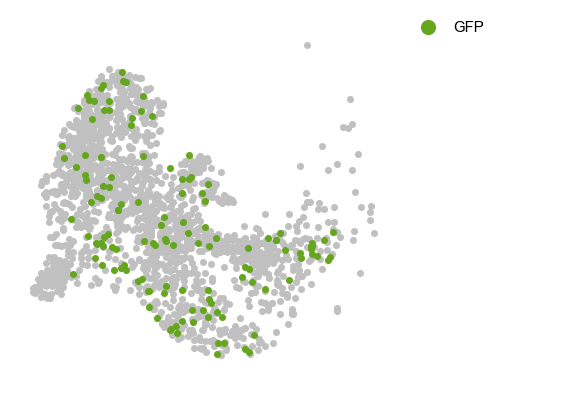

In [37]:
draw_scatter_groups_individual(Xs[TMX_10d].obsm['X_umap_pca'], 
                    Xs[TMX_10d].obs['lineage_tracing'],
                    cmap=cmap_lineage_tracing,
                    s=50, show_axes = False)

## Comparison of 3d and 10d distribution of GFP cells in subsampled data

In [37]:
cells_GFP_3d = Xs[TMX_3d].obs[Xs[TMX_3d].obs['lineage_tracing']=='GFP'].index
cells_GFP_10d = Xs[TMX_10d].obs[Xs[TMX_10d].obs['lineage_tracing']=='GFP'].index

In [38]:
n_sample = np.min([len(cells_GFP_3d), len(cells_GFP_10d)])

In [39]:
n_sample

129

In [40]:
sample_GFP_3d = pd.Series(0, index = TMX_3d)
sample_GFP_3d[np.random.choice(cells_GFP_3d, n_sample, replace=False)] = 1

In [41]:
sample_GFP_10d = pd.Series(0, index = TMX_10d)
sample_GFP_10d[np.random.choice(cells_GFP_10d, n_sample, replace=False)] = 1

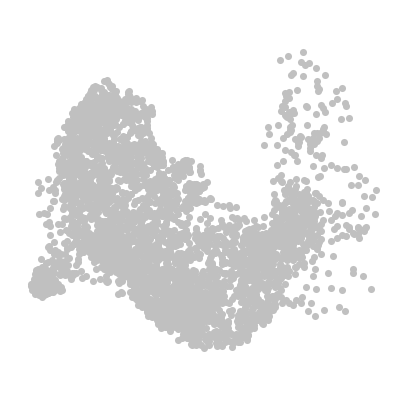

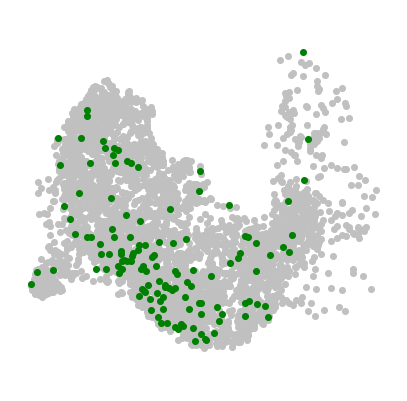

In [42]:
draw_scatter_groups_individual(Xs[TMX_3d].obsm['X_umap_pca'], 
                    sample_GFP_3d,
                    cmap={0:'silver',1:'green'},
                    s=50, show_axes = False, show_legend=False)
figname = 'UMAP_GFP_3d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

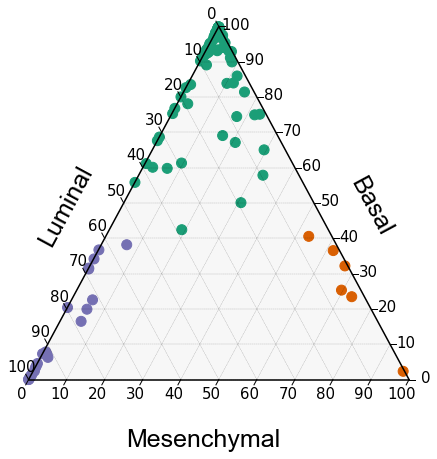

In [43]:
    c_tmp = sample_GFP_3d[sample_GFP_3d==1].index
    dat = list(zip(Xs[c_tmp].obs['pheno_prob2_pca']*100, 
                   Xs[c_tmp].obs['pheno_prob1_pca']*100,
                   Xs[c_tmp].obs['pheno_prob0_pca']*100))
    cmap = {0:'#7570b3',1:'#1b9e77',2:'#d95f02',None:'silver'}
    clist = [cmap[i] for i in Xs[c_tmp].obs['pheno_class_pca']]

    ## Boundary and Gridlines
    scale = 100
    figure, tax = ternary.figure(scale=scale)
    figure.set_figheight(7.5)
    figure.set_figwidth(7.5)

    # Draw Boundary and Gridlines
    tax.boundary(linewidth=1.5)
    tax.gridlines(color="black", multiple=10, linewidth=0.25)
    #tax.gridlines(color="black", multiple=5, linewidth=0.5)

    # Set Axis labels and Title
    fontsize = 25
    offset = 0.15
    #tax.set_title(i, fontsize=fontsize, family='Arial')
    tax.left_axis_label("Luminal", fontsize=fontsize, offset=offset, family='Arial', ha='center')
    tax.right_axis_label("Basal", fontsize=fontsize, offset=offset, family='Arial', ha='center')
    tax.bottom_axis_label("Mesenchymal", fontsize=fontsize, offset=offset, family='Arial', ha='center')

    # Set ticks
    tax.ticks(axis='lbr', linewidth=1, multiple=10, offset=0.015, fontsize=15)

    # Background color
    tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially

    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')

    #plot scatter

    tax.scatter(dat, s=100, color = clist)
    
    figname = 'ternary_sc_autoch_GFP_3d.pdf'
    plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)
    

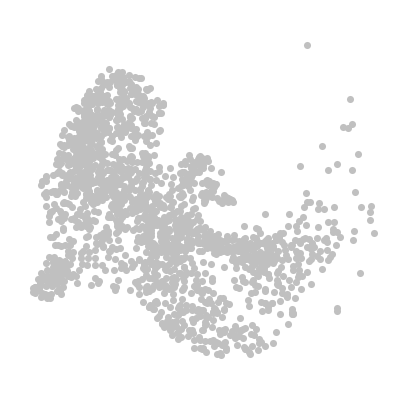

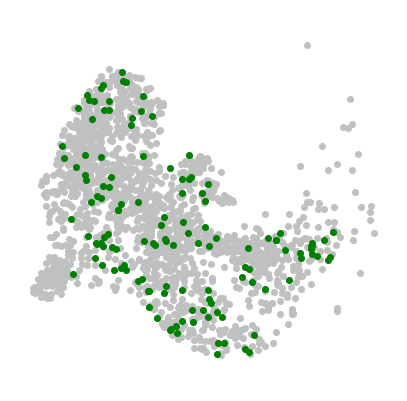

In [44]:
draw_scatter_groups_individual(Xs[TMX_10d].obsm['X_umap_pca'], 
                    sample_GFP_10d,
                    cmap={0:'silver',1:'green'},
                    s=50, show_axes = False, show_legend=False)
figname = 'UMAP_GFP_10d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

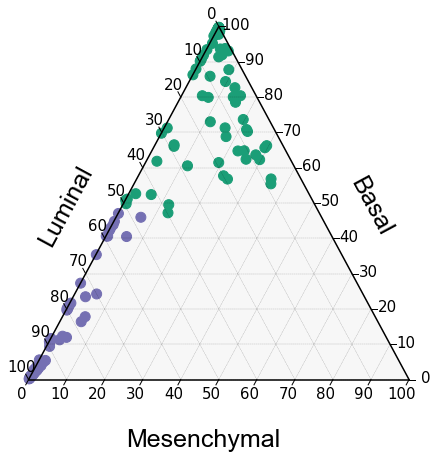

In [45]:
    c_tmp = sample_GFP_10d[sample_GFP_10d==1].index
    dat = list(zip(Xs[c_tmp].obs['pheno_prob2_pca']*100, 
                   Xs[c_tmp].obs['pheno_prob1_pca']*100,
                   Xs[c_tmp].obs['pheno_prob0_pca']*100))
    cmap = {0:'#7570b3',1:'#1b9e77',2:'#d95f02',None:'silver'}
    clist = [cmap[i] for i in Xs[c_tmp].obs['pheno_class_pca']]

    ## Boundary and Gridlines
    scale = 100
    figure, tax = ternary.figure(scale=scale)
    figure.set_figheight(7.5)
    figure.set_figwidth(7.5)

    # Draw Boundary and Gridlines
    tax.boundary(linewidth=1.5)
    tax.gridlines(color="black", multiple=10, linewidth=0.25)
    #tax.gridlines(color="black", multiple=5, linewidth=0.5)

    # Set Axis labels and Title
    fontsize = 25
    offset = 0.15
    #tax.set_title(i, fontsize=fontsize, family='Arial')
    tax.left_axis_label("Luminal", fontsize=fontsize, offset=offset, family='Arial', ha='center')
    tax.right_axis_label("Basal", fontsize=fontsize, offset=offset, family='Arial', ha='center')
    tax.bottom_axis_label("Mesenchymal", fontsize=fontsize, offset=offset, family='Arial', ha='center')

    # Set ticks
    tax.ticks(axis='lbr', linewidth=1, multiple=10, offset=0.015, fontsize=15)

    # Background color
    tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially

    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')

    #plot scatter

    tax.scatter(dat, s=100, color = clist)
    
    figname = 'ternary_sc_autoch_GFP_10d.pdf'
    plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

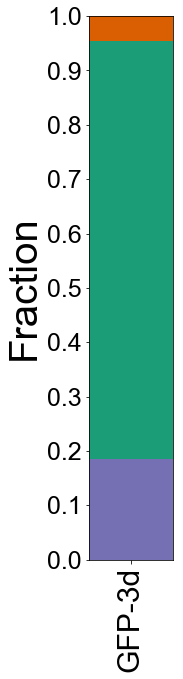

In [57]:
c_tmp = sample_GFP_3d[sample_GFP_3d==1].index
draw_fraction_cluster(Xs.obs['LT*time'][c_tmp], 
                      Xs.obs['pheno_class_pca'][c_tmp], 
                      {0:'#7570b3',1:'#1b9e77',2:'#d95f02'},
                      #cl_order = c_sel,
                      var_order=[0,1,2])

figname = 'fraction_auto_GFP_3d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

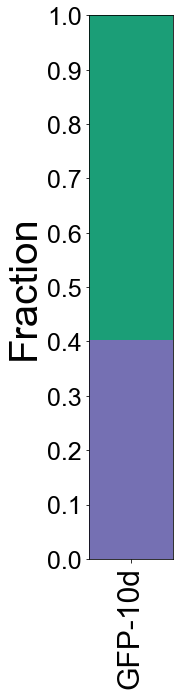

In [58]:
c_tmp = sample_GFP_10d[sample_GFP_10d==1].index
draw_fraction_cluster(Xs.obs['LT*time'][c_tmp], 
                      Xs.obs['pheno_class_pca'][c_tmp], 
                      {0:'#7570b3',1:'#1b9e77',2:'#d95f02'},
                      #cl_order = c_sel,
                      var_order=[0,1,2])

figname = 'fraction_auto_GFP_10d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

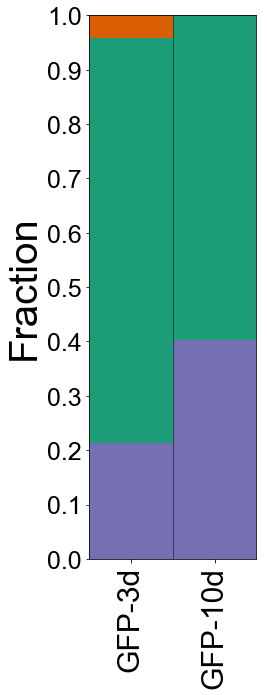

In [56]:
c_sel = Xs.obs['LT*time'][Xs.obs['LT*time'].isin(['GFP-3d','GFP-10d'])].index
draw_fraction_cluster(Xs.obs['LT*time'][c_sel], 
                      Xs.obs['pheno_class_pca'][c_sel], 
                      {0:'#7570b3',1:'#1b9e77',2:'#d95f02'},
                      cl_order = ['GFP-3d','GFP-10d'],
                      var_order=[0,1,2])

# Spatial bias - 3 vs. 10 days - KDE

In [46]:
def calculate_cell_density(coords, groups, 
                           kernel='gaussian', bw=0.5,
                           msk_kernel='tophat', msk_bw=1, 
                           n_bins=500, pad=2, 
                           quant_trans=True):
    
    from sklearn.neighbors import KernelDensity
    from sklearn.preprocessing import quantile_transform
    
    #define x- and y-limits

    x_min, x_max = np.min(coords[:,0]), np.max(coords[:,0])
    y_min, y_max = np.min(coords[:,1]), np.max(coords[:,1])
    x_diff, y_diff = x_max - x_min, y_max - y_min
    x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

    pad = pad

    if x_diff > y_diff:
        xlim = (x_min - pad, x_max + pad)
        ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

    if x_diff < y_diff:
        xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad)
        ylim = (y_min - pad, y_max + pad)
        
    #create grid for scoring
    
    x = np.linspace(xlim[0], xlim[1], n_bins)
    y = np.linspace(ylim[0], ylim[1], n_bins)
    X,Y = np.meshgrid(y, x)
    xy = np.vstack([Y.ravel(), X.ravel()]).T
    
    #fit KDE over complete dataset to define mask
    
    kde = KernelDensity(kernel=msk_kernel, bandwidth=msk_bw).fit(coords)    
    Z = np.exp(kde.score_samples(xy))
    mask = np.isclose(Z,0)
    
    #define ouput
    
    out = pd.DataFrame(index = tuple(xy), columns = return_unique(groups))
    
    #fit KDE over groups 
    
    for g in return_unique(groups):
        kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(coords[groups==g])    
        Z = np.exp(kde.score_samples(xy))
        Z[mask] = None #set none to not condsider in scaling
        out[g] = Z
        
    #quantile transform
    
    if quant_trans:
        out = pd.DataFrame(quantile_transform(out), index = out.index, columns = out.columns)
        
    #out = out.fillna(0)
    
    return out

In [47]:
def draw_density(dens, limits=None, text = None,  cmap = plt.cm.viridis, pad = 2, s = 50, 
                 show_axes = True, show_legend=True, label=None, plot_entropy=False):
    
    dat = dens
        
    if type(limits) == tuple:
        vmin,vmax = limits[0], limits[1]
        dat = np.clip(dat, a_min=vmin, a_max=vmax)
    else:
        abs_ = np.max(np.abs([dat.min(), dat.max()]))
        vmin,vmax = -abs_, abs_
    
    shape = int(np.sqrt(len(dat)))
    dat = np.reshape(dat.values, newshape=(shape,shape))

    x = np.array([i[0] for i in dens.index])
    X = np.reshape(x, newshape=(shape,shape))

    y = np.array([i[1] for i in dens.index])
    Y = np.reshape(y, newshape=(shape,shape))
    
    #initialize figure

    height = 7
    width = 7.5
    plt.figure(facecolor = 'w', figsize = (width, height))
    gs = plt.GridSpec(1,2, wspace=0.25, width_ratios=[7,.5])
    
    ax = plt.subplot(gs[0])
    
    #plot data
    ax.contourf(X, Y, dat, levels=np.linspace(vmin, vmax, 1000), cmap=cmap)

    #text
    
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    
    if text:
        ax.text(xlim[0] + (xlim[1]-xlim[0]) / 2,
                ylim[1] * 1.1,
                text,
                family='Arial',
                fontsize = 20, va = 'center', ha = 'center')
        
    if not show_axes:
        clean_axis(ax)
        
    #plot Shannon entropy
    
    if plot_entropy:
        ent = scipy.stats.entropy(dens[~np.isnan(dens)].values)
        ax.text(xlim[0] + (xlim[1]-xlim[0]) / 2,
                ylim[1] * 1.025,
                'H(X) = %s' % ent,
                family='Arial',
                fontsize = 15, va = 'center', ha = 'center')
    
    #plot colorbar
    
    if show_legend:

        ax = plt.subplot(gs[1])

        ax.set_xlim(0,1)
        ax.set_xticks([])

        ax.set_ylim(vmin, vmax)
        ax.yaxis.set_ticks_position('right')
        
        ax.set_ylabel(label, family='Arial', fontsize=30)
        ax.yaxis.set_label_position('right')
        
        for i in np.linspace(vmin, vmax, 100):
            ax.axhspan(i, i + (vmax-vmin) / 100, color = cmap((i-vmin)/(vmax-vmin)))

In [48]:
def draw_density_vs(dens, vs, limits= None, text = None,  cmap = plt.cm.viridis, pad = 2, s = 50, 
                    show_axes = True, show_legend=True):
    
    if type(vs) == list:
        assert len(vs) == 2, 'vs must contain two keys'
        dat = dens[vs[0]] - dens[vs[1]]      
    elif type(vs) == str:
        dat = dens[vs] - dens[[i for i in dens.columns if i != vs]].mean(axis=1)
        vs = [vs, 'other']

    if type(limits) == tuple:
        vmin,vmax = limits[0], limits[1]
        dat = np.clip(dat, a_min=vmin, a_max=vmax) 
    else:
        abs_ = np.max(np.abs([dat.min(), dat.max()]))
        vmin,vmax = -abs_, abs_
        
    shape = int(np.sqrt(len(dat)))
    dat = np.reshape(dat.values, newshape=(shape,shape))

    x = np.array([i[0] for i in dens.index])
    X = np.reshape(x, newshape=(shape,shape))

    y = np.array([i[1] for i in dens.index])
    Y = np.reshape(y, newshape=(shape,shape))

    #initialize figure

    height = 7
    width = 7.5
    plt.figure(facecolor = 'w', figsize = (width, height))
    gs = plt.GridSpec(1,2, wspace=0.25, width_ratios=[7,.5])
    
    ax = plt.subplot(gs[0])
    
    #plot data

    ax.contourf(X, Y, dat, levels=np.linspace(vmin, vmax, 1000), cmap=cmap)

    #text
    
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    
    if text:
        ax.text(xlim[0] + (xlim[1]-xlim[0]) / 2,
                ylim[1] * 1.05,
                text,
                family='Arial',
                fontsize = 20, va = 'center', ha = 'center')
        
    if not show_axes:
        clean_axis(ax)
    
    #plot colorbar
    
    if show_legend:

        ax = plt.subplot(gs[1])

        ax.set_xlim(0,1)
        ax.set_xticks([])

        ax.set_ylim(vmin, vmax)
        #ax.set_yticks([])

        for i in np.linspace(vmin, vmax, 100):
            ax.axhspan(i, i + (vmax-vmin) / 100, color = cmap((i-vmin)/(vmax-vmin)))
            
        ax.text(0.5,vmax+((vmax-vmin)*0.05),vs[0],family='Arial',fontsize=25,ha='center',va='center')
        ax.text(0.5,vmin-((vmax-vmin)*0.05),vs[1],family='Arial',fontsize=25,ha='center',va='center')

In [49]:
Xs.obs['LT*time'] = ['%s-3d' % Xs.obs['lineage_tracing'][i] if i in TMX_3d else '%s-10d' % Xs.obs['lineage_tracing'][i] for i in Xs.obs_names]
Xs.obs['LT*mouse'] = ['%s-%s' % (Xs.obs['lineage_tracing'][i], Xs.obs['mouse'][i]) for i in Xs.obs_names]

In [49]:
dens_all = calculate_cell_density(Xs.obsm['X_umap_pca'], Xs.obs['treatment'], kernel='gaussian', n_bins=100, bw=3, pad = 5, quant_trans=False)

In [50]:
dens_lineage_tracing = calculate_cell_density(Xs.obsm['X_umap_pca'], Xs.obs['LT*time'], kernel='gaussian',n_bins=100, bw=3, pad = 5, quant_trans=False)

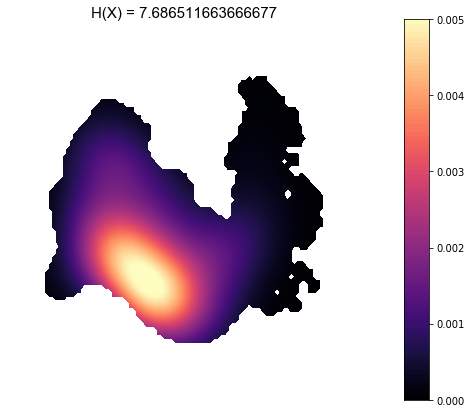

In [51]:
draw_density(dens_lineage_tracing['GFP-3d'],
             cmap=plt.cm.magma, 
             show_axes=False, limits = (0,0.005), plot_entropy=True)

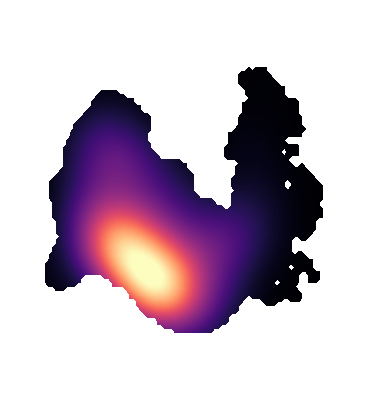

In [63]:
draw_density(dens_lineage_tracing['GFP-3d'],
             cmap=plt.cm.magma, 
             show_axes=False, limits = (0,0.005), plot_entropy=False, show_legend=False)
figname = 'density_GFP_3d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

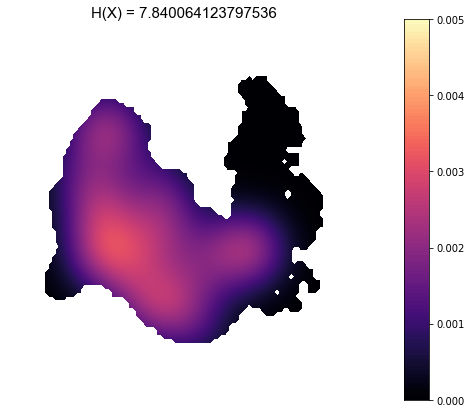

In [52]:
draw_density(dens_lineage_tracing['GFP-10d'], 
             cmap=plt.cm.magma, 
             show_axes=False, limits = (0,0.005), plot_entropy=True)

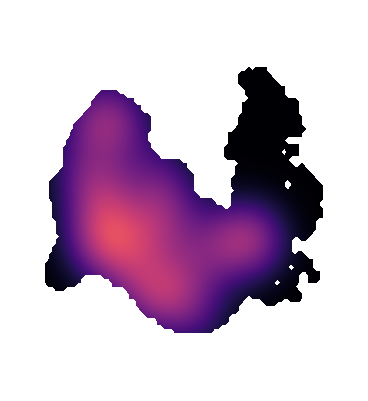

In [64]:
draw_density(dens_lineage_tracing['GFP-10d'],
             cmap=plt.cm.magma, 
             show_axes=False, limits = (0,0.005), plot_entropy=False, show_legend=False)
figname = 'density_GFP_10d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

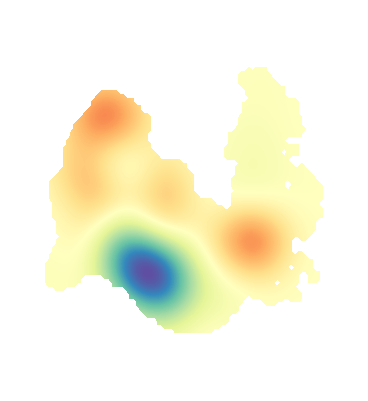

In [66]:
draw_density_vs(dens_lineage_tracing, ['GFP-3d','GFP-10d'], limits= [-0.01,0.01], text = None,  cmap = plt.cm.Spectral, pad = 2, s = 50, 
                    show_axes = False, show_legend=False)
figname = 'density_GFP_diff.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

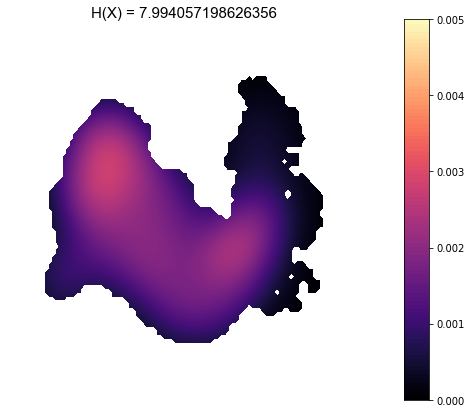

In [54]:
draw_density(dens_lineage_tracing['tdTomato-3d'], 
             cmap=plt.cm.magma, 
             show_axes=False, limits = (0,0.005), plot_entropy=True)

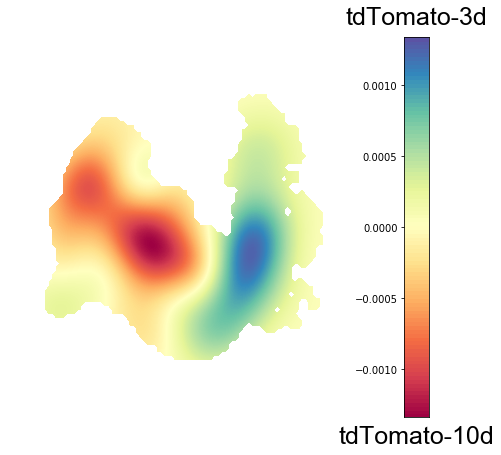

In [61]:
draw_density_vs(dens_lineage_tracing, ['tdTomato-3d','tdTomato-10d'], limits= [-0.01,0.01], text = None,  cmap = plt.cm.Spectral, pad = 2, s = 50, 
                    show_axes = False, show_legend=True)

## Phenotypic volume

In [39]:
def sample_phenotypic_volume(dat, grps, n_it, dview, sample=1000, replace=True):
    
    ####################
    
    def get_phenotypic_volume(dat):
    
        cov = np.cov(dat)
        eigval = np.linalg.eig(cov)[0]
        phenovolume = np.sum(np.log(eigval[~np.isclose(eigval,0)]))

        return phenovolume
    
    ####################
    
    out = pd.DataFrame(index=return_unique(grps), 
                       columns=range(n_it))
    
    for g in return_unique(grps):
        c_gr = grps[grps==g].index
        
        for i in range(n_it):
            c_it = np.random.choice(c_gr, size=sample, replace=replace)
        
            out.loc[g, i] = get_phenotypic_volume(dat[c_it])
        
    return out

In [40]:
pdX = sc2pd(Xs, 'norm_log2')

In [43]:
pv_LT_time = sample_phenotypic_volume(pdX, Xs.obs['LT*time'], 100, dview, sample=50, replace=False)

In [44]:
pv_LT_mouse = sample_phenotypic_volume(pdX, Xs.obs['LT*mouse'], 100, dview, sample=20, replace=False)

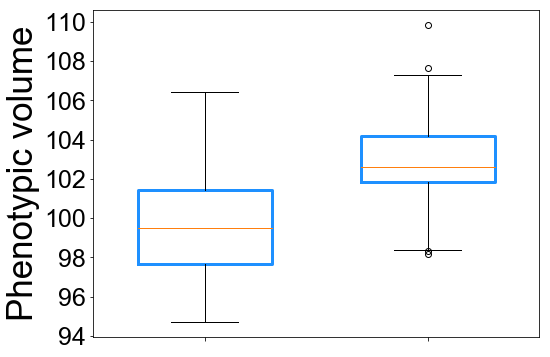

In [47]:
dat = pv_LT_time
gr_order = ['GFP-3d','GFP-10d']
cmap = {'GFP-3d':'dodgerblue','GFP-10d':'dodgerblue'}
clist = [cmap[i] for i in gr_order]

L = len(gr_order)

#initialize figure

height = 6
width = 4 * L

plt.figure(facecolor = 'w', figsize = (width, height))

#define x and y axes

ax = plt.subplot()

ax.set_xlim(-0.5, L-0.5)
ax.set_xticks(range(L))

ax.set_ylabel('Phenotypic volume', family = 'Arial', fontsize = 35)
for tick_pos, tick in enumerate(ax.yaxis.get_major_ticks()):
    ax.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
    ax.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)

#plot data
    
box = ax.boxplot(x=[dat.loc[i] for i in gr_order], positions = range(L), widths = 0.6)

for p,b in enumerate(box['boxes']):
            b.set_c(clist[p])
            b.set_lw(3)

ax.set_xticklabels([], family = 'Arial', fontsize = 20, rotation = 'vertical', )

figname = 'pv_GFP_autochthonous.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Compositional entropy

In [46]:
comp_tumor_GFP = pd.DataFrame(index=['3d','10d'], columns = ['0','1','2','ent'])

for p,i in enumerate([cells_GFP_3d, cells_GFP_10d]):
    l=len(i)
    cnt_tmp = Counter(Xs.obs['pheno_class_pca'][i])
    comp_tumor_GFP.iloc[p][0:3] = np.array([cnt_tmp[0], cnt_tmp[1], cnt_tmp[2]])/l
    comp_tumor_GFP['ent'].iloc[p] = scipy.stats.entropy(list(comp_tumor_GFP[['0','1','2']].iloc[p]))

In [47]:
it = 100
n = 50
ent_GFP_rs = pd.DataFrame(index = ['3d','10d'], columns = range(it))

for p,q in enumerate([cells_GFP_3d, cells_GFP_10d]):
    for i in range(it):
        c_tmp = np.random.choice(q,n,replace=False)
        cnt_tmp = Counter(Xs.obs['pheno_class_pca'][c_tmp])
        ent_GFP_rs.iloc[p][i] = scipy.stats.entropy(np.array([cnt_tmp[0], cnt_tmp[1], cnt_tmp[2]])/n)

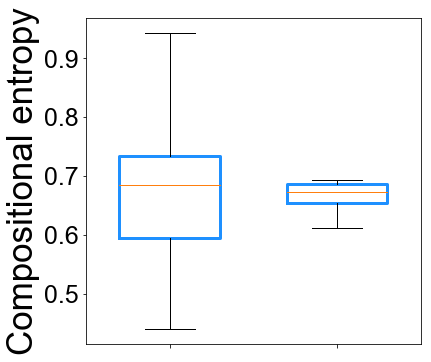

In [49]:
dat = ent_GFP_rs
gr_order = ['3d','10d']
cmap = {'3d':'dodgerblue','10d':'dodgerblue','20d':'dodgerblue'}
clist = [cmap[i] for i in gr_order]

L = len(gr_order)

#initialize figure

height = 6
width = 3 * L

plt.figure(facecolor = 'w', figsize = (width, height))

#define x and y axes

ax = plt.subplot()

ax.set_xlim(-0.5, L-0.5)
ax.set_xticks(range(L))

ax.set_ylabel('Compositional entropy', family = 'Arial', fontsize = 35)
for tick_pos, tick in enumerate(ax.yaxis.get_major_ticks()):
    ax.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
    ax.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)

#plot data
    
#plot data
    
box = ax.boxplot(x=[dat.loc[i] for i in gr_order], positions = range(L), widths = 0.6)

for p,b in enumerate(box['boxes']):
            b.set_c(clist[p])
            b.set_lw(3)

ax.set_xticklabels([], family = 'Arial', fontsize = 20, rotation = 'vertical', )

figname = 'ent_GFP_autoch.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Pseudotime distribution

In [51]:
def draw_violin_pseudotime(adata, dpt_var, group_var, cmap=plt.cm.tab20, gr_order=None, scatter=False, bw='scott'):
    
    assert dpt_var in adata.obs.columns, 'dpt_var not in adata'
    dpt = adata.obs[dpt_var]
    
    assert group_var in adata.obs.columns, 'group_var not in adata'
    groups = adata.obs[group_var]
    
    if not gr_order:
        gr_order = return_unique(groups)
        
    L = len(set(gr_order))
    
    #initialize figure

    height = 1 * L
    width = 10

    plt.figure(facecolor = 'w', figsize = (width, height))
    
    #define colormap
    
    if type(cmap) != dict:
        cm = cmap
        cmap = {}
        for ix, gr in enumerate(return_unique(groups)):
            cmap[gr] = cm(float(ix) / 20)
            
    clist = [cmap[c] for c in gr_order]
    
    #define x and y axes

    ax = plt.subplot()
    
    ax.set_xlim(0,1)
    ax.set_xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    ax.set_xticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], family = 'Arial', fontsize = 20, rotation = 'vertical')
    ax.set_xlabel('Pseudotime', family = 'Arial', fontsize = 30)
    
    ax.set_ylim(L-0.5,-0.5)
    ax.set_yticks(range(0,L))
    ax.set_yticklabels(gr_order, family = 'Arial', fontsize = 20)

    
    #plot data

    for p, i in enumerate(gr_order):

        i_tmp = groups[groups==i].index
        d_tmp = dpt[i_tmp].values
        
        if scatter:
            ax.scatter(d_tmp,
                       [p-(i-0.5)/2 for i in np.random.rand(len(d_tmp), 1)],
                        color = 'k',
                        s = 5,
                        alpha = 0.25,
                        zorder = 1)

        violin = ax.violinplot([d_tmp],
                                positions = [p],
                                vert=False,
                                showextrema=False,
                                widths=0.95, 
                               bw_method=bw)

        for v in violin['bodies']:
            v.set_facecolor(cmap[i])
            v.set_linewidth(0)
            v.set_alpha(0.75)
            v.set_zorder(0)

        ax.axhline(p, color='k', linewidth=2)

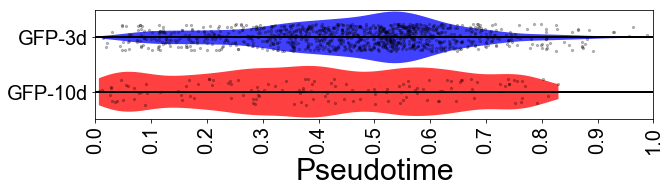

In [53]:
draw_violin_pseudotime(Xs, 
                       'dpt_pseudotime_pca', 
                       'LT*time', 
                       cmap={'GFP-3d':'blue','GFP-10d':'red'}, 
                       gr_order=['GFP-3d','GFP-10d'], 
                       bw=0.2, scatter=True)